1) Importing the library

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from scipy.stats import ks_2samp
from scipy.special import rel_entr

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

2) Bring FashionMNIST and random split at 70:30 (seed fixed)

In [2]:
to_tensor = transforms.ToTensor()
full = datasets.FashionMNIST('.', train=True, download=True, transform=to_tensor)

n = len(full)
nA = int(0.7 * n)
nB = n - nA
A, B_raw = random_split(full, [nA, nB], generator=torch.Generator().manual_seed(42))

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]


3) Distribution change check functions

In [3]:
# KS test based on pixel mean
def pixel_means(ds, sample_size=1000):
    imgs, _ = next(iter(DataLoader(ds, batch_size=sample_size, shuffle=True)))
    return imgs.view(sample_size, -1).mean(1).numpy()

In [4]:
# KL Divergence
def kl_div(a, b, bins=50):
    hA, _ = np.histogram(a, bins=bins, range=(0,1), density=True)
    hB, _ = np.histogram(b, bins=bins, range=(0,1), density=True)
    hA += 1e-8; hB += 1e-8
    return np.sum(rel_entr(hA, hB))

In [5]:
# Domain_auc
def domain_auc(ds1, ds2, sample_size=1000):
    imgs1, _ = next(iter(DataLoader(ds1, batch_size=sample_size, shuffle=True)))
    imgs2, _ = next(iter(DataLoader(ds2, batch_size=sample_size, shuffle=True)))
    X = torch.cat([imgs1, imgs2], dim=0).view(2*sample_size, -1).numpy()
    y = np.array([0]*sample_size + [1]*sample_size)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=2000).fit(X_tr, y_tr)
    return roc_auc_score(y_te, clf.predict_proba(X_te)[:,1])

4) Baseline analysis (A vs. B_raw, same distribution)

---- Baseline (no shift) ----
KS stat: 0.0290, p-value: 0.7947
AUC     : 0.5436
KL div  : 1.4617


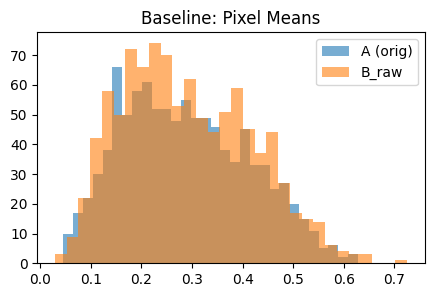

In [6]:
mean_A = pixel_means(A)
mean_B = pixel_means(B_raw)

ks0, p0 = ks_2samp(mean_A, mean_B)
auc0     = domain_auc(A, B_raw)
kl0      = kl_div(mean_A, mean_B)

print("---- Baseline (no shift) ----")
print(f"KS stat: {ks0:.4f}, p-value: {p0:.4f}")
print(f"AUC     : {auc0:.4f}")
print(f"KL div  : {kl0:.4f}")

plt.figure(figsize=(5,3))
plt.hist(mean_A, bins=30, alpha=0.6, label='A (orig)')
plt.hist(mean_B, bins=30, alpha=0.6, label='B_raw')
plt.title("Baseline: Pixel Means")
plt.legend()
plt.show()

5) Shift applied to dataset B (resolution, brightness, class balance)

In [7]:
# Covariate shift
transform_shift = transforms.Compose([
    transforms.Resize(7),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x + 0.1).clamp(0,1))
])
B_shift = datasets.FashionMNIST('.', train=True, download=True, transform=transform_shift)

In [8]:
# Label shift
targs = np.array(B_shift.targets)
idx7  = np.where(targs==7)[0]
keep7 = np.random.choice(idx7, size=int(0.1*len(idx7)), replace=False)
keep_idx = [i for i, t in enumerate(targs) if t!=7 or i in keep7]
B_shift.data    = B_shift.data[keep_idx]
B_shift.targets = targs[keep_idx]

6) Shifted Analysis (A vs B_shift)


---- Shifted (with transform) ----
KS stat: 0.3440, p-value: 0.0000
AUC     : 1.0000
KL div  : 112.8645


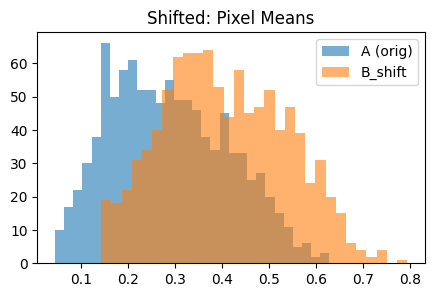

In [9]:
mean_Bs = pixel_means(B_shift)

ks1, p1 = ks_2samp(mean_A, mean_Bs)
auc1     = domain_auc(A, B_shift)
kl1      = kl_div(mean_A, mean_Bs)

print("\n---- Shifted (with transform) ----")
print(f"KS stat: {ks1:.4f}, p-value: {p1:.4f}")
print(f"AUC     : {auc1:.4f}")
print(f"KL div  : {kl1:.4f}")

plt.figure(figsize=(5,3))
plt.hist(mean_A,  bins=30, alpha=0.6, label='A (orig)')
plt.hist(mean_Bs, bins=30, alpha=0.6, label='B_shift')
plt.title("Shifted: Pixel Means")
plt.legend()
plt.show()

7) Check Sample Image

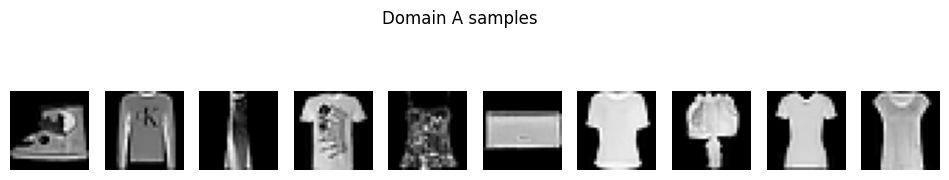

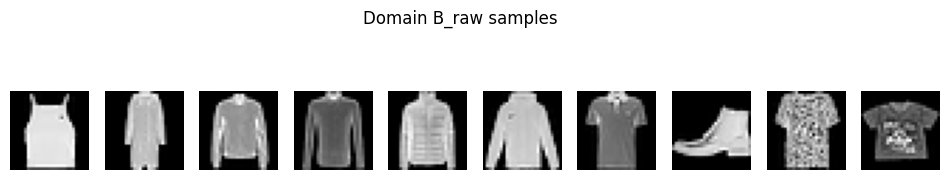

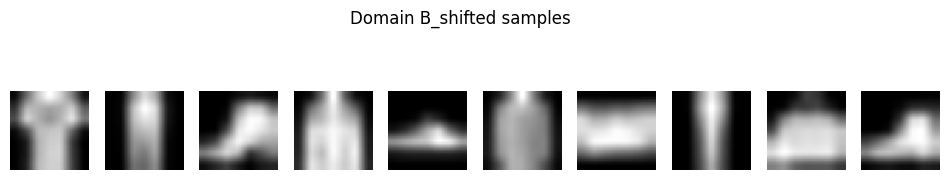

In [10]:
def show(ds, title):
    imgs, _ = next(iter(DataLoader(ds, batch_size=10, shuffle=True)))
    fig, axes = plt.subplots(1,10,figsize=(12,2))
    for i,ax in enumerate(axes):
        ax.imshow(imgs[i].squeeze(), cmap='gray'); ax.axis('off')
    plt.suptitle(title, y=1.1)
    plt.show()

show(A,      "Domain A samples")
show(B_raw, "Domain B_raw samples")
show(B_shift,"Domain B_shifted samples")

8) Apply to model

In [12]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

bs = 128
loader_A     = DataLoader(A, batch_size=bs, shuffle=True,  num_workers=2)
loader_A_eval= DataLoader(A, batch_size=bs, shuffle=False, num_workers=2)
loader_Bs    = DataLoader(B_shift,     batch_size=bs, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)


model.conv1 = nn.Conv2d(1, 64,
                        kernel_size=7, stride=2, padding=3, bias=False)

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [13]:
def train_one_epoch():
    model.train()
    running = 0.0
    for imgs, labs in loader_A:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(loader_A.dataset)

def eval_loader(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            out  = model(imgs)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.append(pred)
            trues.append(labs.numpy())
    return np.concatenate(preds), np.concatenate(trues)


In [14]:
epochs = 3
for ep in range(1, epochs+1):
    loss = train_one_epoch()
    print(f"Epoch {ep}/{epochs} — train loss: {loss:.4f}")

# In-domain (A→A)
pred_A, true_A = eval_loader(loader_A_eval)
acc_A = accuracy_score(true_A, pred_A)
print(f"\nAccuracy on A (in-domain): {acc_A:.4f}")

# Out-of-domain (A→B_shift)
pred_Bs, true_Bs = eval_loader(loader_Bs)
acc_Bs = accuracy_score(true_Bs, pred_Bs)
print(f"Accuracy on B_shift (out-of-domain): {acc_Bs:.4f}\n")

print("Classification Report on B_shift:")
print(classification_report(true_Bs, pred_Bs, digits=4))

Epoch 1/3 — train loss: 0.5944
Epoch 2/3 — train loss: 0.3656
Epoch 3/3 — train loss: 0.3061

Accuracy on A (in-domain): 0.9075
Accuracy on B_shift (out-of-domain): 0.3398

Classification Report on B_shift:
              precision    recall  f1-score   support

           0     0.3168    0.4607    0.3754      6000
           1     0.6833    0.8148    0.7433      6000
           2     0.2681    0.7128    0.3897      6000
           3     0.5455    0.0020    0.0040      6000
           4     0.7132    0.2263    0.3436      6000
           5     1.0000    0.0005    0.0010      6000
           6     0.0634    0.0517    0.0570      6000
           7     0.0000    0.0000    0.0000       600
           8     0.2856    0.7327    0.4110      6000
           9     0.9732    0.0908    0.1662      6000

    accuracy                         0.3398     54600
   macro avg     0.4849    0.3092    0.2491     54600
weighted avg     0.5329    0.3398    0.2737     54600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
